# IMDb Sentiment Analysis - Exploratory Data Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
import numpy as np
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import CountVectorizer

# Download stopwords if not already present
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Load the IMDB dataset
df = pd.read_csv("../data/raw/IMDB Dataset.csv")

In [ ]:
# Text cleaning function to remove HTML and non-alphabetic characters
def clean_text(text):
    text = re.sub(
        r"<br\s*/?>", " ", text
    )  # Replace HTML line breaks with space
    text = re.sub(r"<.*?>", "", text)  # Remove remaining HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    return text


# Set of stopwords for filtering, with custom additions
stop_words = set(stopwords.words("english")).union({"br", "im", "ive", "ve"})

In [ ]:
# Print dataset info and distribution of sentiment labels
print(df.info())
print(df["sentiment"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [5]:
# Remove duplicate reviews to avoid bias
df = df.drop_duplicates()

In [ ]:
# Add features for number of words and characters per review
df["word_count"] = df["review"].apply(lambda x: len(x.split()))
df["char_count"] = df["review"].apply(len)

## Sentiment Class Distribution

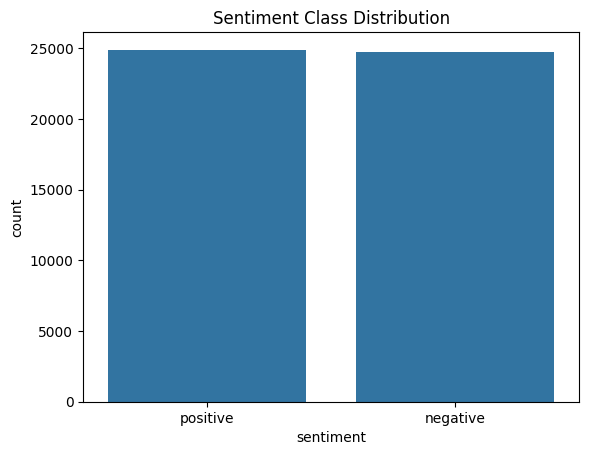

In [ ]:
sns.countplot(x="sentiment", data=df)
plt.title("Sentiment Class Distribution")
plt.show()

The dataset is perfectly balanced between positive and negative reviews, which eliminates the need for class rebalancing.

## Review Length Distribution

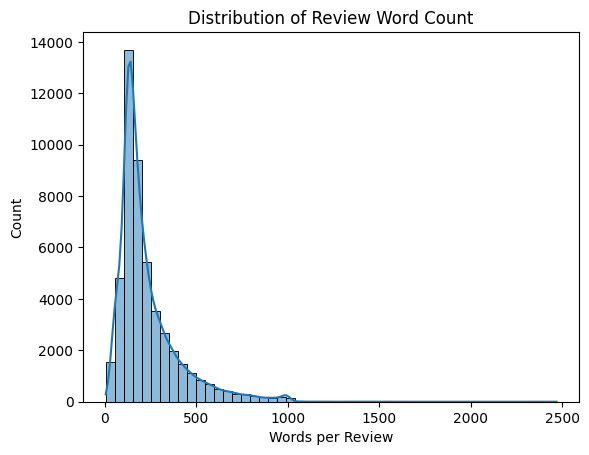

In [ ]:
# Plot histogram with kernel density estimate of word counts
sns.histplot(df["word_count"], bins=50, kde=True)
plt.title("Distribution of Review Word Count")
plt.xlabel("Words per Review")
plt.show()

Most reviews fall between 100 and 400 words. The distribution is right-skewed with a long tail.

## Review Length by Sentiment

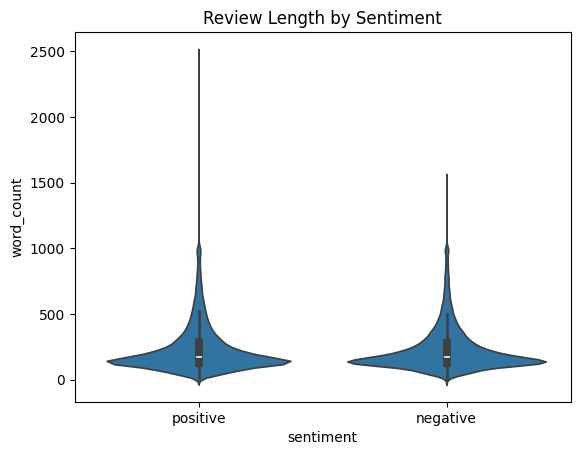

In [ ]:
# Violin plot helps visualize density and spread better for skewed data
# It comparing review length across sentiment labels
sns.violinplot(x="sentiment", y="word_count", data=df)
plt.title("Review Length by Sentiment")
plt.show()

Positive reviews tend to be slightly longer than negative ones, though the overlap is substantial.

## Sentiment Distribution by Review Length Bin

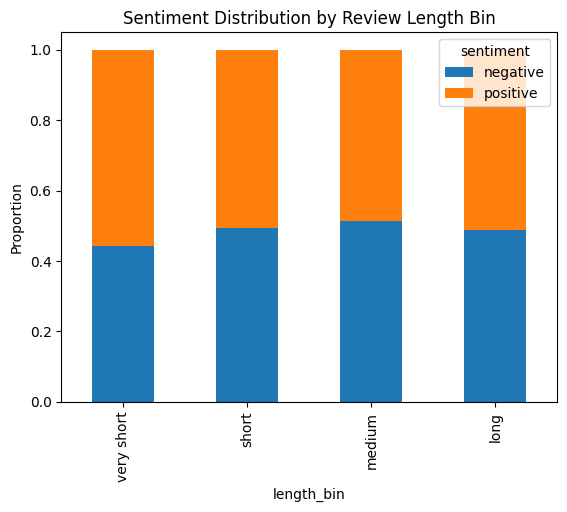

In [ ]:
bins = [0, 50, 150, 300, 5000]
labels = ["very short", "short", "medium", "long"]
df["length_bin"] = pd.cut(df["word_count"], bins=bins, labels=labels)

bin_sentiment = pd.crosstab(
    df["length_bin"], df["sentiment"], normalize="index"
)
bin_sentiment.plot(kind="bar", stacked=True)
plt.title("Sentiment Distribution by Review Length Bin")
plt.ylabel("Proportion")
plt.show()

## Hypothesis Testing (T-Test)

In [ ]:
pos = df[df.sentiment == "positive"]["word_count"]
neg = df[df.sentiment == "negative"]["word_count"]
t_stat, p_val = ttest_ind(pos, neg, equal_var=False)
print(f"T-test for word count: t-stat={t_stat:.4f}, p-val={p_val:.4e}")

T-test for word count: t-stat=2.2684, p-val=2.3309e-02


The difference in average review length between sentiments is statistically significant (p < 0.05).

## Lexical Features

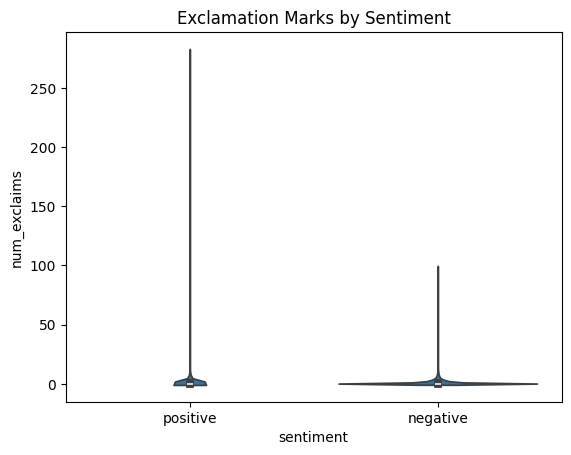

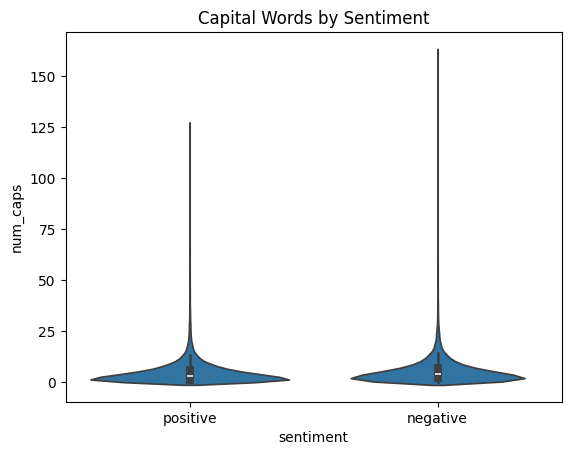

In [ ]:
df["num_exclaims"] = df["review"].apply(lambda x: x.count("!"))
df["num_caps"] = df["review"].apply(
    lambda x: sum(1 for w in x.split() if w.isupper())
)
sns.violinplot(x="sentiment", y="num_exclaims", data=df)
plt.title("Exclamation Marks by Sentiment")
plt.show()

sns.violinplot(x="sentiment", y="num_caps", data=df)
plt.title("Capital Words by Sentiment")
plt.show()

Negative reviews tend to use more exclamation marks and capitalized words, indicating higher emotional tone.

## Top Words by Sentiment
Compare most frequent non-stopwords by sentiment.

In [ ]:
# Extract most common words per sentiment
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        tokens = clean_text(text).split()
        words.extend([w for w in tokens if w not in stop_words])
    return Counter(words).most_common(n)


# Print top 20 words for each class
print("Top words in positive reviews:")
print(get_top_words(df[df.sentiment == "positive"]["review"]))

print("Top words in negative reviews:")
print(get_top_words(df[df.sentiment == "negative"]["review"]))

Top words in positive reviews:
[('film', 40030), ('movie', 36522), ('one', 26185), ('like', 17123), ('good', 14515), ('great', 12738), ('story', 12578), ('time', 12082), ('see', 11935), ('well', 11367), ('also', 10697), ('really', 10687), ('would', 10335), ('even', 9443), ('much', 9071), ('first', 8945), ('films', 8563), ('love', 8466), ('people', 8439), ('best', 8359)]
Top words in negative reviews:
[('movie', 48040), ('film', 35472), ('one', 24909), ('like', 21622), ('even', 14941), ('bad', 14214), ('good', 14196), ('would', 13503), ('really', 12156), ('time', 11693), ('see', 10501), ('dont', 10161), ('get', 9922), ('much', 9873), ('story', 9798), ('people', 9108), ('could', 8940), ('make', 8932), ('movies', 8436), ('made', 8381)]


**Positive Reviews**

| Word                            | Meaning / Interpretation                                                                               |
| ------------------------------- | ------------------------------------------------------------------------------------------------------ |
| `film`, `movie`, `films`        | Neutral terms, often present regardless of sentiment. High frequency suggests general discussion.      |
| `good`, `great`, `best`, `love` | Strong positive sentiment indicators. Clear signals of satisfaction.                                   |
| `story`, `time`, `first`        | Often used in context of enjoyment, engagement, or nostalgia (“great story”, “first time I saw this”). |
| `well`, `really`, `also`        | Reinforcing or amplifying tone — often used in favorable descriptions.                                 |
| `would`, `see`, `like`          | Express desire or past enjoyment (“would recommend”, “liked it”, “must see”).                          |
| `people`                        | May refer to actors, audience, or universal relatability (“people should watch this”).                 |

**Negative Reviews**

| Word                                   | Meaning / Interpretation                                                                                                           |
| -------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| `bad`, `dont`, `could`, `make`, `made` | Clear expressions of **disappointment** or **criticism**. Used in “bad acting”, “don’t waste your time”, “could have been better”. |
| `even`, `really`, `much`, `get`        | Used to **emphasize frustration** or **confusion** (“didn’t even try”, “really bad”, “much worse than expected”).                  |
| `movies`, `story`, `people`            | Reflect **discontent with content or characters**. Common phrasing: “the story was weak”, “people overhyped it”.                   |
| `would`, `see`, `like`                 | Present in both sets — meaning depends on phrasing (“I would not recommend”, “didn’t like it”).                                    |

**Overlapping Words**

* `movie`, `film`, `one`, `like`, `really`, `much`, `people`, `story`, `see`, `would`, `time` all appear in both sentiments.
* These are **context-sensitive** and need surrounding words or n-grams to infer tone.
* Words like `good` appear in both, but context is key (e.g., “not good” vs. “very good”).

**Insights for Feature Engineering**

1. **Positive-only signals**: `great`, `love`, `best`, `highly`
2. **Negative-only signals**: `bad`, `dont`, `waste`, `could`, `make`
3. **Use TF-IDF with context** to downweigh generic terms like `movie`, `film`.


## Word Clouds

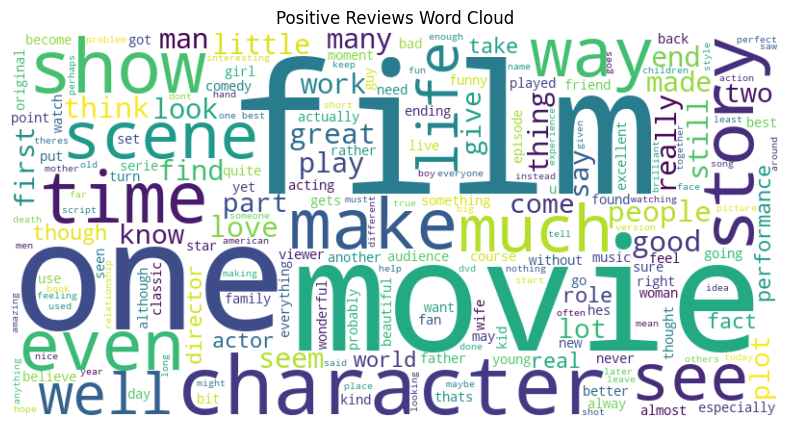

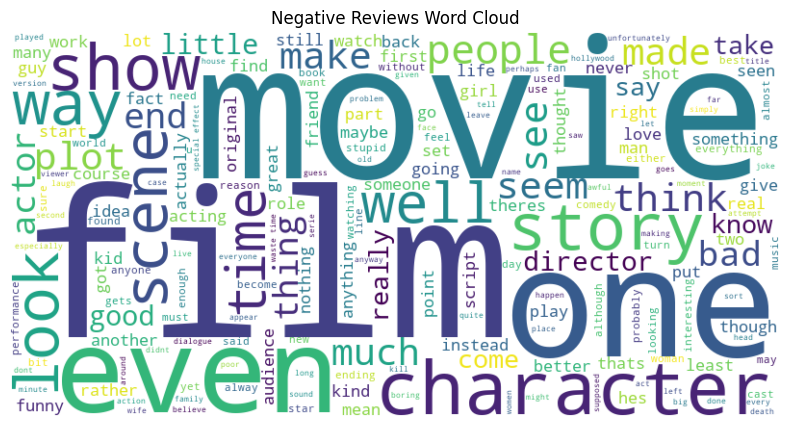

In [ ]:
def show_wordcloud(texts, title):
    cleaned = [
        " ".join([w for w in clean_text(text).split() if w not in stop_words])
        for text in texts
    ]
    wc = WordCloud(width=800, height=400, background_color="white").generate(
        " ".join(cleaned)
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()


show_wordcloud(
    df[df.sentiment == "positive"]["review"], "Positive Reviews Word Cloud"
)
show_wordcloud(
    df[df.sentiment == "negative"]["review"], "Negative Reviews Word Cloud"
)

Word clouds visually reinforce token differences between sentiments — positive reviews show words like "good" and "love," while negatives highlight "bad" and "even."

## Bigram Frequency

This bigram frequency data gives useful insights into how **phrases differ between positive and negative reviews**, and which expressions commonly reflect sentiment.

In [ ]:
# Extract top bigrams
def get_top_ngrams(texts, ngram_range=(2, 2), n=20):
    # Clean each review and remove stopwords
    cleaned = [
        " ".join([w for w in clean_text(text).split() if w not in stop_words])
        for text in texts
    ]
    cv = CountVectorizer(ngram_range=ngram_range, stop_words="english")
    X = cv.fit_transform(cleaned)
    freqs = zip(cv.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    return sorted(freqs, key=lambda x: -x[1])[:n]


# Print bigrams by sentiment
print("Top bigrams in positive reviews:")
print(get_top_ngrams(df[df.sentiment == "positive"]["review"]))

print("Top bigrams in negative reviews:")
print(get_top_ngrams(df[df.sentiment == "negative"]["review"]))

Top bigrams in positive reviews:
[('dont know', 906), ('new york', 814), ('special effects', 771), ('years ago', 727), ('great movie', 702), ('good movie', 695), ('real life', 591), ('pretty good', 577), ('dont think', 570), ('watch movie', 569), ('saw movie', 568), ('great film', 561), ('years later', 557), ('really good', 546), ('high school', 524), ('love story', 507), ('highly recommend', 502), ('long time', 501), ('movie great', 460), ('year old', 458)]
Top bigrams in negative reviews:
[('waste time', 1394), ('special effects', 1384), ('dont know', 1298), ('looks like', 1249), ('look like', 944), ('bad movie', 876), ('low budget', 846), ('watch movie', 765), ('worst movie', 734), ('dont think', 724), ('good movie', 715), ('really bad', 706), ('bad acting', 660), ('watching movie', 658), ('movie bad', 657), ('movie like', 654), ('main character', 639), ('horror movie', 625), ('movie seen', 616), ('year old', 612)]


- **Positive reviews** often highlight quality (`great`, `recommend`), emotional tone (`love`, `nostalgia`), and specific film features (`special effects`, `storyline`).

- **Negative reviews** focus on **regret**, **poor production**, and **critical comparisons**. They tend to use more definitive and harsh wording.

- **Interesting Overlaps**: **`special effects`**, `dont know`, `dont think`, `good movie`, `watch movie`, and `year old` appear in *both* positive and negative reviews. This suggests these bigrams are **context-dependent** and should not be used alone for classification.

**Conclusion**

1. **Distinctive bigrams** like `waste time`, `highly recommend`, `worst movie` are highly predictive.
2. **Overlapping bigrams** need to be considered **with surrounding context** to avoid misclassification.
3. Consider **bigram sentiment polarity** as features (e.g., `good movie` = +1, `bad movie` = -1).

## Outlier Examples
Very short reviews are typically harsh or blunt. Extremely long reviews often provide detailed praise or critique.

In [ ]:
# Filter extreme lengths
long_reviews = df[df["word_count"] > 1000]
short_reviews = df[df["word_count"] < 10]

# Show samples
print("\nSample very long review:")
print(long_reviews.iloc[0]["review"][:500])

print("\nSample very short review:")
print(short_reviews.iloc[0]["review"])


Sample very long review:
Some people drift through life, moving from one thing or one person to the next without batting an eye; others latch on to a cause, another person or a principle and remain adamant, committed to whatever it is-- and figuratively or literally they give their word and stand by it. But we're all different, `Made of different clay,' as one of the characters in this film puts it, which is what makes life so interesting. Some people are just plain crazy, though-- and maybe that's the way you have to b

Sample very short review:
More suspenseful, more subtle, much, much more disturbing....


## Named Entity Recognition (NER)
Using spaCy to extract named entities from the text.

In [17]:
! python -m spacy download en_core_web_sm
import spacy

nlp = spacy.load("en_core_web_sm")

# Extract named entities for first few samples
df['entities'] = df['review'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

# View some results
df[['review', 'entities']].head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.5 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


,review,entities
0,One of the other reviewers has mentioned that ...,"[(One, CARDINAL), (1, CARDINAL), (GO, ORG), (O..."
1,A wonderful little production. <br /><br />The...,"[(BBC, ORG), (Michael Sheen, PERSON), (William..."
2,I thought this was a wonderful way to spend ti...,"[(summer weekend, DATE), (Match Point 2, PERSO..."
3,Basically there's a family where a little boy ...,"[(Jake, NORP), (Jake, NORP), (Rambo, PERSON), ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...","[(Love, WORK_OF_ART), (Mattei, PERSON), (Arthu..."


In [ ]:
# Count the most common entity types
all_entities = [ent[1] for ents in df["entities"] for ent in ents]
entity_type_counts = Counter(all_entities)
print("Most common entity types:")
print(entity_type_counts.most_common(10))

Most common entity types:
[('PERSON', 231111), ('ORG', 85078), ('CARDINAL', 67428), ('DATE', 47359), ('GPE', 45250), ('NORP', 33701), ('WORK_OF_ART', 25683), ('ORDINAL', 20791), ('TIME', 14386), ('LOC', 5827)]


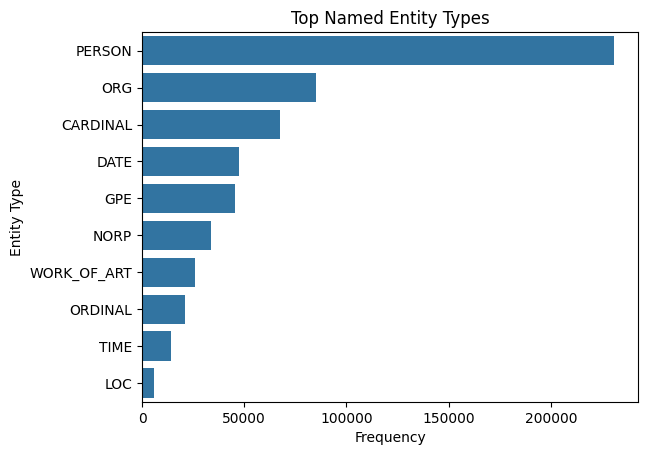

In [ ]:
# Plot top entity types
entity_type_df = pd.DataFrame(
    entity_type_counts.items(), columns=["Entity Type", "Count"]
).sort_values(by="Count", ascending=False)
sns.barplot(data=entity_type_df.head(10), x="Count", y="Entity Type")
plt.title("Top Named Entity Types")
plt.xlabel("Frequency")
plt.ylabel("Entity Type")
plt.show()

1. **High `PERSON` and `WORK_OF_ART` counts** reflect the nature of movie reviews, which often mention actors, directors, and film titles.
2. **Frequent `CARDINAL`, `ORDINAL`, and `TIME` entities** indicate that users often reference rankings, counts, or durations (e.g., “three stars”, “second act”, “90 minutes”).
3. **`DATE` and `GPE`** might suggest review contexts — when/where a movie was released or watched.
4. **`ORG` and `NORP`** might be helpful for domain adaptation, such as filtering by studio or cultural background.

**Possible Usage**

* **Entity-based Filtering**: Group reviews by referenced film title, actor, or year.
* **Bias Detection**: Track overrepresentation of certain nationalities or groups (`NORP`, `GPE`).
* **Feature Engineering**: Count of named entities as a signal of informativeness or complexity.

## Sentiment Scoring with TextBlob

`TextBlob` is a simple Python library for NLP that provides **rule-based** sentiment analysis using pre-trained lexicons. Its sentiment scoring includes two key metrics:

**1. Polarity**

* **Range**: `-1.0` (most negative) to `+1.0` (most positive)
* **Meaning**: Indicates the emotional tone of the sentence.

  * `+1.0` = very positive
  * `0.0` = neutral
  * `-1.0` = very negative

**2. Subjectivity**

* **Range**: `0.0` (very objective) to `1.0` (very subjective)
* **Meaning**: Measures how **opinionated or personal** the sentence is.

  * `1.0` = highly subjective (e.g., opinions, feelings)
  * `0.0` = highly objective (e.g., facts, data)

**How It Works Internally**

TextBlob uses a lexicon called **PatternAnalyzer**, which assigns:

* Positive/negative sentiment scores to individual words.
* Modifies intensity using surrounding context (negation, adverbs).

It **doesn’t use ML or context awareness**, so it’s fast and interpretable — but less accurate for nuanced text.

**When to Use It**

* Great for quick, lightweight analysis.
* Useful for exploratory data analysis (EDA), plotting polarity distributions.
* Not suitable as a production model for sentiment classification on nuanced or domain-specific text.

In [ ]:
from textblob import TextBlob

df["polarity"] = df["review"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["subjectivity"] = df["review"].apply(
    lambda x: TextBlob(x).sentiment.subjectivity
)

# Display distribution
df[["polarity", "subjectivity"]].describe()

,polarity,subjectivity
count,49582.000000,49582.000000
mean,0.103693,0.530613
std,0.163179,0.092839
min,-1.000000,0.000000
25%,0.004402,0.472222
50%,0.104884,0.528825
75%,0.203521,0.587664
max,1.000000,1.000000


In [ ]:
# Categorize polarity direction
df["polarity_label"] = df["polarity"].apply(
    lambda p: "positive" if p > 0 else "negative" if p < 0 else "neutral"
)

# Show distribution of sentiment polarity categories
print(df["polarity_label"].value_counts(normalize=True))

polarity_label
positive    0.759328
negative    0.240047
neutral     0.000625
Name: proportion, dtype: float64


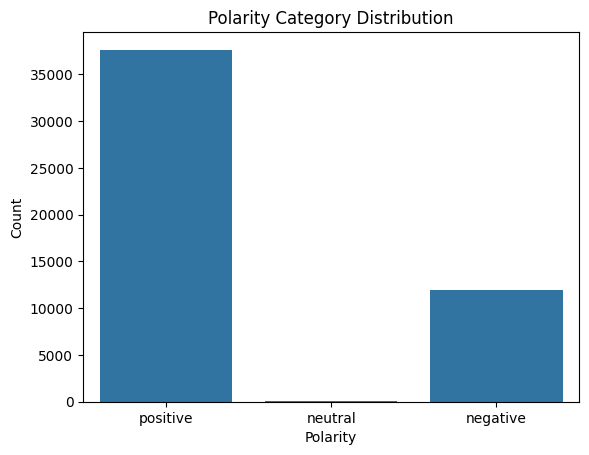

In [ ]:
# Plot sentiment distribution
sns.countplot(
    data=df, x="polarity_label", order=["positive", "neutral", "negative"]
)
plt.title("Polarity Category Distribution")
plt.xlabel("Polarity")
plt.ylabel("Count")
plt.show()

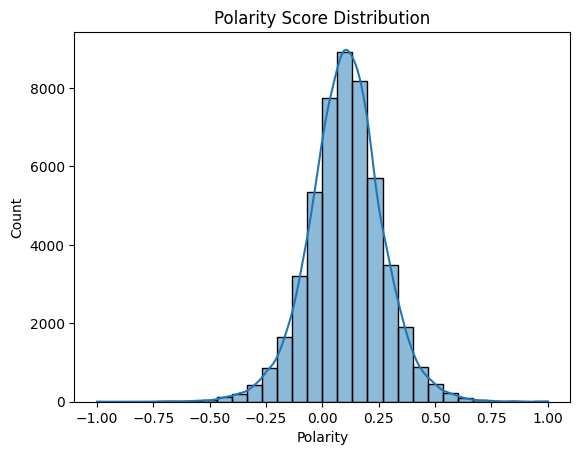

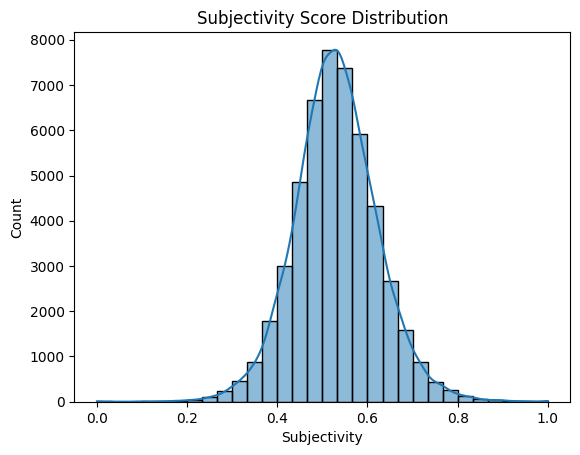

In [ ]:
# Distribution of polarity and subjectivity
sns.histplot(data=df, x="polarity", bins=30, kde=True)
plt.title("Polarity Score Distribution")
plt.xlabel("Polarity")
plt.show()

sns.histplot(data=df, x="subjectivity", bins=30, kde=True)
plt.title("Subjectivity Score Distribution")
plt.xlabel("Subjectivity")
plt.show()

From the Polarity and Subjectivity distribution, the dataset contains more positive tone, and a good balance between stating the fact and emotional opinion.